# Train a CNN on the color-based training set.
Finally got Tensorflow to use CUDA and GPU in notebook 12.  
Finally got CNN to learn in notebook 13.  
Since we can't load all the images, learn to use TensorFlow Data API.

Directory structure is
* cache  
    * train  
        * 0  (green) 2680 files
        * 1   (blue) 3099 files
    * valid  
        * 0  (green) 266 files
        * 1   (blue) 311 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
BLUE=1
GREEN=0

In [3]:
# TO DO: normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1./255)

In [4]:
# TO DO: load patches in random order
# TO DO: or, give patch files randome names
class patch_loader:
    def __init__(self):
        pass
    def load_pixel_array(self,filename):
        im = Image.open(filename)
        ima = np.array(im)   # convert to numpy
        return ima
    def load_dataset(self,path,tv,label,max_files=None):
        file_count=0
        images=[]
        labels=[]
        pstr = path+tv+'/'+str(label)+'/*.tif'
        fullpaths = glob.glob(pstr)
        # names = [os.path.basename(x) for x in fullpaths]
        for name in fullpaths:
            file_count += 1
            if file_count <= max_files:
                ima = self.load_pixel_array(name)
                images.append(ima)
                labels.append(label)
        return images,labels

In [5]:
pl = patch_loader()
TSAMPLES=50
VSAMPLES=20

greenX,greenY = pl.load_dataset(DIR_IMAGES_IN,'train',GREEN,max_files=TSAMPLES)
blueX, blueY =  pl.load_dataset(DIR_IMAGES_IN,'train',BLUE,max_files=TSAMPLES)
X_train = greenX + blueX
Y_train = greenY + blueY

greenX,greenY = pl.load_dataset(DIR_IMAGES_IN,'valid',GREEN,max_files=VSAMPLES)
blueX, blueY =  pl.load_dataset(DIR_IMAGES_IN,'valid',BLUE,max_files=VSAMPLES)
X_valid = greenX + blueX
Y_valid = greenY + blueY

# Required for tensorflow+
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid)
Y_valid = np.asarray(Y_valid)

In [6]:
print(Y_train)
print(type(X_train))
print(len(X_train))
print(X_train[0].shape)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.ndarray'>
100
(224, 224, 3)


In [7]:
ACTIVATION="tanh"
NUM_CLASSES = 2
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation=ACTIVATION,padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(128,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [8]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=15
start = time.time()
hist = cnn.fit(X_train,Y_train,shuffle=True,epochs=EPOCHS,
                 validation_data=(X_valid,Y_valid))
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/15
4/4 [==============================] - 4s 325ms/step - loss: 1.9650 - accuracy: 0.5500 - val_loss: 2.6231 - val_accuracy: 0.5000
Epoch 2/15
4/4 [==============================] - 0s 80ms/step - loss: 1.8400 - accuracy: 0.5000 - val_loss: 0.2580 - val_accuracy: 0.9750
Epoch 3/15
4/4 [==============================] - 0s 80ms/step - loss: 0.3637 - accuracy: 0.8200 - val_loss: 0.0495 - val_accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 0s 80ms/step - loss: 0.2270 - accuracy: 0.9200 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 5/15
4/4 [==============================] - 0s 80ms/step - loss: 0.2079 - accuracy: 0.9500 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 6/15
4/4 [==============================] - 0s 80ms/step - loss: 0.1544 - accuracy: 0.9500 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 0s 80ms/step - loss: 0.1077 - accuracy: 0.9800 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 8/15
4/4 [==========

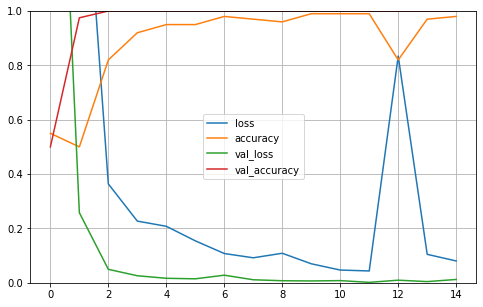

In [9]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()